In [1]:
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from kaggle_data_loader import KaggleDataLoader
from kaggle_dataset import KaggleDataSet

e:\life\edu\NU-DAE\IE 7500 - NLP\Proj\venv-nlp-proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kaggle_path = "kritanjalijain/amazon-reviews"
data_column_names = [KaggleDataSet.POLARITY_COLUMN_NAME, 
                     KaggleDataSet.TITLE_COLUMN_NAME,
                     KaggleDataSet.REVIEW_COLUMN_NAME]

kaggle_data_loader = KaggleDataLoader(kaggle_path)
path = kaggle_data_loader.load_data(data_column_names)

print("Path to dataset files:", path)
print(path)
print(os.listdir(path))

kaggle_dataset = KaggleDataSet(kaggle_data_loader)
train_df = kaggle_dataset.get_train_df()
test_df = kaggle_dataset.get_test_df()

print(train_df.head())

train_texts = train_df[KaggleDataSet.REVIEW_COLUMN_NAME].tolist()
test_texts = test_df[KaggleDataSet.REVIEW_COLUMN_NAME].tolist()

train_labels = (train_df[KaggleDataSet.POLARITY_COLUMN_NAME] - 1).tolist() 
test_labels = (test_df[KaggleDataSet.POLARITY_COLUMN_NAME] - 1).tolist()

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)

100%|██████████| 1.29G/1.29G [00:39<00:00, 35.5MB/s]

Extracting files...


Path to dataset files: C:\Users\User0n3\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
C:\Users\User0n3\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
['amazon_review_polarity_csv.tgz', 'test.csv', 'train.csv']
Path to dataset files: C:\Users\User0n3\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
C:\Users\User0n3\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
['amazon_review_polarity_csv.tgz', 'test.csv', 'train.csv']
   Label                                              Title  \
0      2                     Stuning even for the non-gamer   
1      2              The best soundtrack ever to anything.   
2      2                                           Amazing!   
3      2                               Excellent Soundtrack   
4      2  Remember, Pull Your Jaw Off The Floor After He...   

                                              Review  
0  This sound track was beautiful! It paints the ...  
1  I'm re

In [4]:
print("Unique label counts")
print(train_df[KaggleDataSet.POLARITY_COLUMN_NAME].value_counts())
print(test_df[KaggleDataSet.POLARITY_COLUMN_NAME].value_counts())

Unique label counts
Label
2    1800000
1    1800000
Name: count, dtype: int64
Label
2    200000
1    200000
Name: count, dtype: int64


In [5]:
train_review_lengths = train_df[KaggleDataSet.REVIEW_COLUMN_NAME].str.len()
print("Train dataset, Review column's length:\n")
reformatted_desc = train_review_lengths.describe().round(2)

# Convert from scientific notation to 2 decimal only
print(reformatted_desc.apply(lambda x: f"{x:.2f}"))

Train dataset, Review column's length:

count    3600000.00
mean         405.14
std          234.27
min            4.00
25%          207.00
50%          356.00
75%          566.00
max         1010.00
Name: Review, dtype: object


In [6]:
test_review_lengths = test_df[KaggleDataSet.REVIEW_COLUMN_NAME].str.len()
print("Test dataset, Review column's length:\n")
reformatted_desc = test_review_lengths.describe().round(2)

# Convert from scientific notation to 2 decimal only
print(reformatted_desc.apply(lambda x: f"{x:.2f}"))

Test dataset, Review column's length:

count    400000.00
mean        404.90
std         234.11
min          15.00
25%         207.00
50%         356.00
75%         565.00
max        1009.00
Name: Review, dtype: object


In [11]:
###
### This may take a bit of time to run
###

from itertools import chain

def get_unique_words(series):
    # To lowercase and split into words, handling NaN
    words = (review.lower().split() for review in series if isinstance(review, str))
    # Flatten and convert to set
    return set(chain(*words))


# Apply to 'review' column
unique_words = get_unique_words(train_df[KaggleDataSet.REVIEW_COLUMN_NAME])
num_unique_words = len(unique_words)

print(f"Number of unique words in all the reviews: {num_unique_words}")

Number of unique words in all the reviews: 4069197


In [7]:
### Generate word cloud for the title column

avg_title_length = int(round(train_df[KaggleDataSet.TITLE_COLUMN_NAME].str.len().mean()))
print(f"Average Title length {avg_title_length}")

title_wordcloud = WordCloud(background_color='black', max_words=avg_title_length).generate(str(train_df[KaggleDataSet.TITLE_COLUMN_NAME]))

Average Title length 25


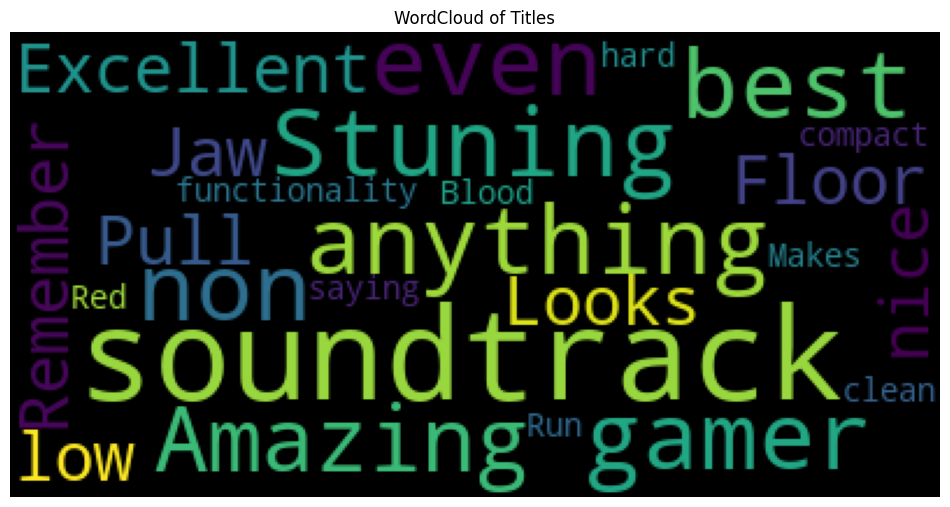

In [8]:
fig = plt.figure(figsize=[12,12])
plt.title('WordCloud of Titles')
plt.axis('off')
plt.imshow(title_wordcloud)
plt.show()

In [9]:
### Generate word cloud for the review column

avg_review_length = int(round(train_df[KaggleDataSet.REVIEW_COLUMN_NAME].str.len().mean()))
print(f"Average Review length {avg_review_length}")

review_wordcloud = WordCloud(background_color='black', max_words=avg_review_length).generate(str(train_df[KaggleDataSet.REVIEW_COLUMN_NAME]))

Average Review length 405


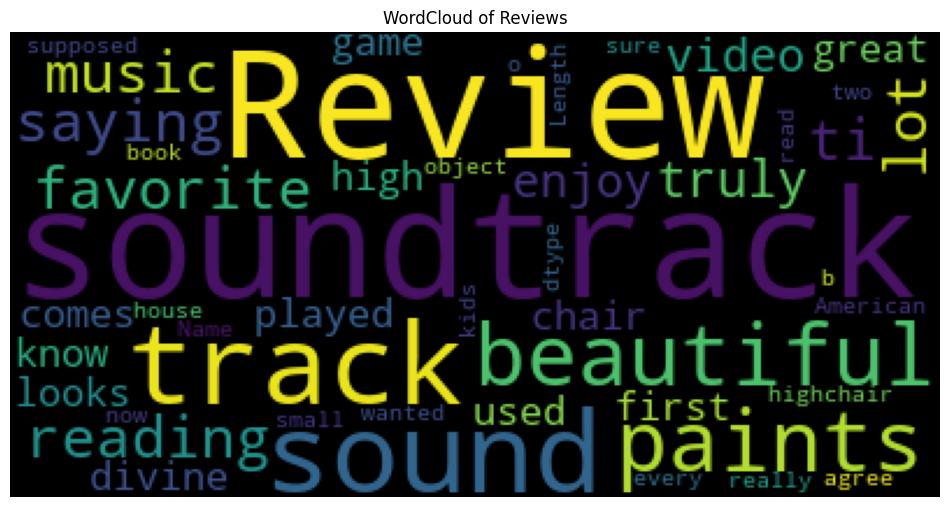

In [10]:
fig = plt.figure(figsize=[12,12])
plt.title('WordCloud of Reviews')
plt.axis('off')
plt.imshow(review_wordcloud)
plt.show()